# HEALTH NEWS

#### Importing libs

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from time import time
import numpy as np
import pandas as pd


from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler

#### Utils

In [6]:
import os, errno

# Subroutine that imports data
def import_data(filename):
    data = pd.read_csv(filename, header=None)
    return data

def get_datasets(data):
    rows, cols = data.shape
    data_training = data.loc[:0.85 * rows, :]
    data_validation = data.loc[0.85 * rows:, :]
    return data_training, data_validation

def import_txt_data(filename):
    fileHandle = open(filename, 'r')
    return fileHandle

def get_news(fileHandle):
    news = []
    next(fileHandle)
    for line in fileHandle:
        fields = line.split('|')
        news.append(fields[2].strip())
    fileHandle.close()
    return news

def silentremove(filename):
    try:
        os.remove(filename)
    except OSError as e:
        if e.errno != errno.ENOENT:
            raise 

np.seterr(divide='ignore', invalid='ignore')

{'divide': 'ignore', 'over': 'warn', 'under': 'ignore', 'invalid': 'ignore'}

#### Reading data

In [8]:
file = 'files/word2vec.csv'
df = import_data(file)
train, validation = get_datasets(df)

file_txt = 'files/health.txt'
fh = import_txt_data(file_txt)
news = get_news(fh)

## Elbow method
The most significant change on the curve is on 2. Looking at the whole curve, the elbow is formed in [1,10].

In [36]:
def elbow(X, k_max=20):
    distorsions = []
    for k in range(1, k_max+1):
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(X)
        distorsions.append(kmeans.inertia_)

    fig = plt.figure(figsize=(15, 5))
    plt.plot(range(1, k_max+1), distorsions)
    plt.grid(True)
    plt.title('Elbow curve')
    
def elbow2(X, k_max=20):
    Nc = range(1, k_max)
    kmeans = [KMeans(n_clusters=i) for i in Nc]
    score = [kmeans[i].fit(X).score(X) for i in range(len(kmeans))]
    
    plt.plot(Nc,score)
    plt.xlabel('Number of Clusters')
    plt.ylabel('Score')
    plt.title('Elbow Curve')
    plt.show()
    

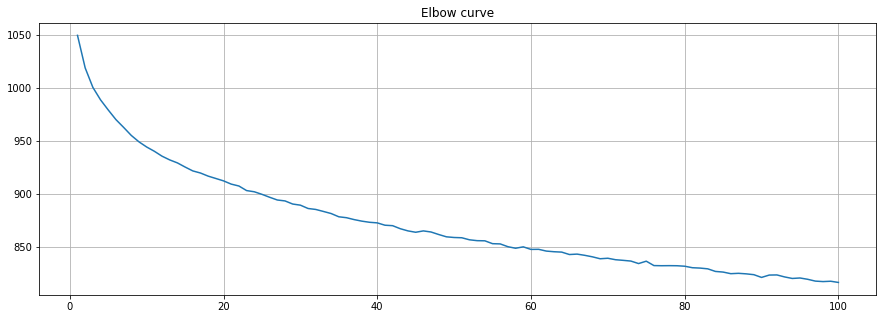

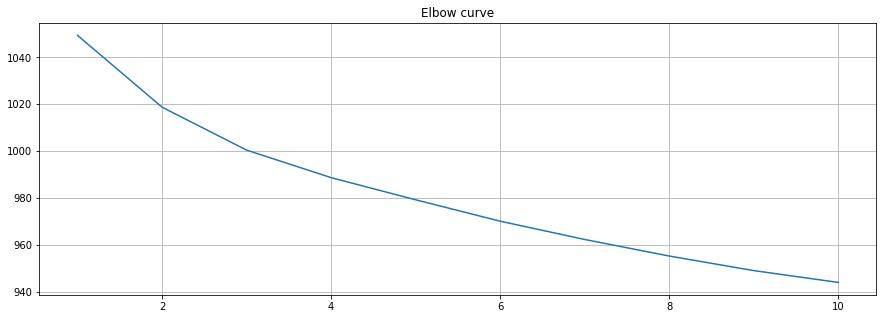

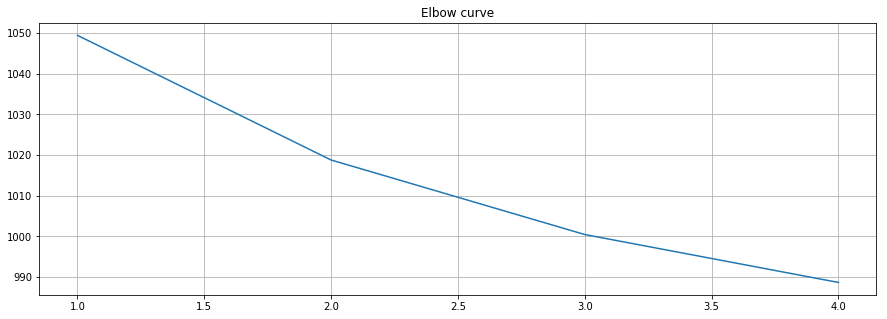

In [40]:
elbow(train, 100)
elbow(train, 10)
elbow(train, 4)

## Gap statistic method
https://www.datanovia.com/en/lessons/determining-the-optimal-number-of-clusters-3-must-know-methods/#average-silhouette-method

https://datasciencelab.wordpress.com/2013/12/27/finding-the-k-in-k-means-clustering/

https://anaconda.org/milesgranger/gap-statistic/notebook

Python implementation of the Gap Statistic by Miles Granger.


In [110]:
def optimalK(data, nrefs=3, maxClusters=15):
    """
    Calculates KMeans optimal K using Gap Statistic from Tibshirani, Walther, Hastie
    Params:
        data: ndarry of shape (n_samples, n_features)
        nrefs: number of sample reference datasets to create
        maxClusters: Maximum number of clusters to test for
    Returns: (gaps, optimalK)
    """
    gaps = np.zeros((len(range(1, maxClusters)),))
    resultsdf = pd.DataFrame({'clusterCount':[], 'gap':[]})
    for gap_index, k in enumerate(range(1, maxClusters)):

        # Holder for reference dispersion results
        refDisps = np.zeros(nrefs)

        # For n references, generate random sample and perform kmeans getting resulting dispersion of each loop
        for i in range(nrefs):
            
            # Create new random reference set
            randomReference = np.random.random_sample(size=data.shape)
            
            # Fit to it
            km = KMeans(k)
            km.fit(randomReference)
            
            refDisp = km.inertia_
            refDisps[i] = refDisp

        # Fit cluster to original data and create dispersion
        km = KMeans(k)
        km.fit(data)
        
        origDisp = km.inertia_

        # Calculate gap statistic
        gap = np.log(np.mean(refDisps)) - np.log(origDisp)

        # Assign this loop's gap statistic to gaps
        gaps[gap_index] = gap
        
        resultsdf = resultsdf.append({'clusterCount':k, 'gap':gap}, ignore_index=True)

    return (gaps.argmax() + 1, resultsdf) 

In [ ]:
# k, gapdf = optimalK(train, nrefs=5, maxClusters=30)
# print('Optimal k is: ', k)

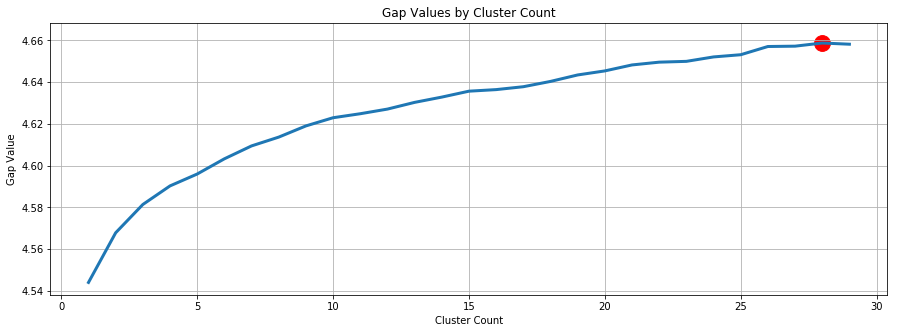

In [72]:
# fig = plt.figure(figsize=(15, 5))
# plt.plot(gapdf.clusterCount, gapdf.gap, linewidth=3)
# plt.scatter(gapdf[gapdf.clusterCount == k].clusterCount, gapdf[gapdf.clusterCount == k].gap, s=250, c='r')
# plt.grid(True)
# plt.xlabel('Cluster Count')
# plt.ylabel('Gap Value')
# plt.title('Gap Values by Cluster Count')
# plt.show()

# Performing K-Means

In [29]:
def run_kmeans(estimator, name, data_train, data_valid):
    t0 = time()
    estimator.fit(data_train)
    
    global centroids
    centroids = estimator.cluster_centers_
    labels = estimator.labels_
    
    print('init \t\t time  \t\t Davies-Bouldin \t silhouette')
    print('%-9s \t %.2fs \t\t %.3f \t\t\t %.3f \n'
          % (name, (time() - t0),
             metrics.davies_bouldin_score(data_train, estimator.labels_),
             metrics.silhouette_score(data_train, estimator.labels_, metric='euclidean', sample_size=None)))
    
    return estimator, centroids, labels

In [30]:
pp_2 = run_kmeans(KMeans(init='k-means++', n_clusters=2), name="k-means++", data_train=train, data_valid=validation)
pp_3 = run_kmeans(KMeans(init='k-means++', n_clusters=3), name="k-means++", data_train=train, data_valid=validation)
pp_5 = run_kmeans(KMeans(init='k-means++', n_clusters=5), name="k-means++", data_train=train, data_valid=validation)
pp_14 = run_kmeans(KMeans(init='k-means++', n_clusters=14), name="k-means++", data_train=train, data_valid=validation)
pp_28 = run_kmeans(KMeans(init='k-means++', n_clusters=28), name="k-means++", data_train=train, data_valid=validation)

pp_2_rand = run_kmeans(KMeans(init='random', n_clusters=2), name="random", data_train=train, data_valid=validation)
pp_3_rand = run_kmeans(KMeans(init='random', n_clusters=3), name="random", data_train=train, data_valid=validation)
pp_5_rand = run_kmeans(KMeans(init='random', n_clusters=5), name="random", data_train=train, data_valid=validation)
pp_14_rand = run_kmeans(KMeans(init='random', n_clusters=14), name="random", data_train=train, data_valid=validation)
pp_28_rand = run_kmeans(KMeans(init='random', n_clusters=28), name="random", data_train=train, data_valid=validation)

init 		 time  		 Davies-Bouldin 	 silhouette
k-means++ 	 1.05s 		 5.449 			 0.042 

init 		 time  		 Davies-Bouldin 	 silhouette
k-means++ 	 1.59s 		 5.023 			 0.002 

init 		 time  		 Davies-Bouldin 	 silhouette
k-means++ 	 2.61s 		 5.519 			 -0.004 

init 		 time  		 Davies-Bouldin 	 silhouette
k-means++ 	 5.09s 		 4.764 			 -0.007 

init 		 time  		 Davies-Bouldin 	 silhouette
k-means++ 	 8.37s 		 4.400 			 -0.000 

init 		 time  		 Davies-Bouldin 	 silhouette
random    	 0.75s 		 5.449 			 0.042 

init 		 time  		 Davies-Bouldin 	 silhouette
random    	 1.51s 		 5.017 			 0.002 

init 		 time  		 Davies-Bouldin 	 silhouette
random    	 2.13s 		 5.430 			 -0.003 

init 		 time  		 Davies-Bouldin 	 silhouette
random    	 4.34s 		 4.803 			 -0.007 

init 		 time  		 Davies-Bouldin 	 silhouette
random    	 6.48s 		 4.640 			 -0.009 



## PCA

Choosing the minimum number of principal components such that 95% of the variance is retained.

In [31]:
# Standardizing the features
scaler = StandardScaler()

scaler.fit(train)

# .95
train_scaled_95 = scaler.transform(train)
# .60
train_scaled_60 = scaler.transform(train)
#.30
train_scaled_30 = scaler.transform(train)

# Make an instance of the Model
pca_95 = PCA(.95)
pca_95.fit(train_scaled_95)

pca_60 = PCA(.60)
pca_60.fit(train_scaled_60)

pca_30 = PCA(.30)
pca_30.fit(train_scaled_30)

print(len(pca_95.explained_variance_ratio_))
print(len(pca_60.explained_variance_ratio_))
print(len(pca_30.explained_variance_ratio_))

114
51
18


In [32]:
train_scaled_95 = pca_95.transform(train_scaled_95)
train_scaled_60 = pca_60.transform(train_scaled_60)
train_scaled_30 = pca_30.transform(train_scaled_30)

### Re-modeling

In [33]:
print("PCA with .95 of variance:")
pca_2_95 = run_kmeans(KMeans(init='k-means++', n_clusters=2), name="k-means++", data_train=train_scaled_95, data_valid=validation)
pca_3_95 = run_kmeans(KMeans(init='k-means++', n_clusters=3), name="k-means++", data_train=train_scaled_95, data_valid=validation)
pca_5_95 = run_kmeans(KMeans(init='k-means++', n_clusters=5), name="k-means++", data_train=train_scaled_95, data_valid=validation)
pca_14_95 = run_kmeans(KMeans(init='k-means++', n_clusters=14), name="k-means++", data_train=train_scaled_95, data_valid=validation)
pca_28_95 = run_kmeans(KMeans(init='k-means++', n_clusters=28), name="k-means++", data_train=train_scaled_95, data_valid=validation)

print("\nPCA with .60 of variance:")
pca_2_60 = run_kmeans(KMeans(init='k-means++', n_clusters=2), name="k-means++", data_train=train_scaled_60, data_valid=validation)
pca_3_60 = run_kmeans(KMeans(init='k-means++', n_clusters=3), name="k-means++", data_train=train_scaled_60, data_valid=validation)
pca_5_60 = run_kmeans(KMeans(init='k-means++', n_clusters=5), name="k-means++", data_train=train_scaled_60, data_valid=validation)
pca_14_60 = run_kmeans(KMeans(init='k-means++', n_clusters=14), name="k-means++", data_train=train_scaled_60, data_valid=validation)
pca_28_60 = run_kmeans(KMeans(init='k-means++', n_clusters=28), name="k-means++", data_train=train_scaled_60, data_valid=validation)

print("\nPCA with .30 of variance:")
pca_2_30 = run_kmeans(KMeans(init='k-means++', n_clusters=2), name="k-means++", data_train=train_scaled_30, data_valid=validation)
pca_3_30 = run_kmeans(KMeans(init='k-means++', n_clusters=3), name="k-means++", data_train=train_scaled_30, data_valid=validation)
pca_5_30 = run_kmeans(KMeans(init='k-means++', n_clusters=5), name="k-means++", data_train=train_scaled_30, data_valid=validation)
pca_14_30 = run_kmeans(KMeans(init='k-means++', n_clusters=14), name="k-means++", data_train=train_scaled_30, data_valid=validation)
pca_28_30 = run_kmeans(KMeans(init='k-means++', n_clusters=28), name="k-means++", data_train=train_scaled_30, data_valid=validation)

PCA with .95 of variance:
init 		 time  		 Davies-Bouldin 	 silhouette
k-means++ 	 0.86s 		 5.475 			 0.042 

init 		 time  		 Davies-Bouldin 	 silhouette
k-means++ 	 1.72s 		 5.034 			 0.003 

init 		 time  		 Davies-Bouldin 	 silhouette
k-means++ 	 2.54s 		 5.205 			 0.003 

init 		 time  		 Davies-Bouldin 	 silhouette
k-means++ 	 4.29s 		 4.929 			 -0.009 

init 		 time  		 Davies-Bouldin 	 silhouette
k-means++ 	 6.54s 		 4.272 			 -0.003 


PCA with .60 of variance:
init 		 time  		 Davies-Bouldin 	 silhouette
k-means++ 	 0.48s 		 4.311 			 0.056 

init 		 time  		 Davies-Bouldin 	 silhouette
k-means++ 	 0.94s 		 3.964 			 0.024 

init 		 time  		 Davies-Bouldin 	 silhouette
k-means++ 	 1.32s 		 3.935 			 0.029 

init 		 time  		 Davies-Bouldin 	 silhouette
k-means++ 	 2.39s 		 3.652 			 0.021 

init 		 time  		 Davies-Bouldin 	 silhouette
k-means++ 	 3.70s 		 3.384 			 0.025 


PCA with .30 of variance:
init 		 time  		 Davies-Bouldin 	 silhouette
k-means++ 	 0.22s 		 2.985 			 0.

## Analysing neighborhood of training dataset

Group the news using the labels for each one.

In [34]:
from collections import defaultdict

def news_by_cluster(labels):
    uq_labels = list(set(labels))
    groups = defaultdict(list)
    
    for i in uq_labels:
        groups[i] = []
    
    for label in enumerate(labels):
        _id, cluster = label
        groups[cluster].append(_id)
    
    return groups

# Find the cluster of a specified news
def find_news_in_cluster(id_news, groups):
    for group in groups:
        if id_news in groups[group]:
            return group

def find_new_by_id(_id):
    return news[_id];

def find_news_by_id_list(id_list):
    news = []
    for _id in id_list:
        news.append(find_new_by_id(_id))
    return news

Return the list of news of each cluster as an index:

In [35]:
g_2 = news_by_cluster(pp_2[2])
g_3 = news_by_cluster(pp_3[2])
g_5 = news_by_cluster(pp_5[2])
g_14 = news_by_cluster(pp_14[2])
g_28 = news_by_cluster(pp_28[2])

g_pca_2_95 = news_by_cluster(pca_2_95[2])
g_pca_3_95 = news_by_cluster(pca_3_95[2])
g_pca_5_95 = news_by_cluster(pca_5_95[2])
g_pca_14_95 = news_by_cluster(pca_14_95[2])
g_pca_28_95 = news_by_cluster(pca_28_95[2])

g_pca_2_60 = news_by_cluster(pca_2_60[2])
g_pca_3_60 = news_by_cluster(pca_3_60[2])
g_pca_5_60 = news_by_cluster(pca_5_60[2])
g_pca_14_60 = news_by_cluster(pca_14_60[2])
g_pca_28_60 = news_by_cluster(pca_28_60[2])

g_pca_2_30 = news_by_cluster(pca_2_30[2])
g_pca_3_30 = news_by_cluster(pca_3_30[2])
g_pca_5_30 = news_by_cluster(pca_5_30[2])
g_pca_14_30 = news_by_cluster(pca_14_30[2])
g_pca_28_30 = news_by_cluster(pca_28_30[2])

Get the N closest news to centroid for each cluster:

In [36]:
from sklearn.metrics.pairwise import euclidean_distances

class News:
    def __init__(self, dist, _id):
        self.dist, self._id = dist, _id

def get_neigh(pp, X, groups, N):
    estimator, centroids, labels = pp
    dists = defaultdict(list)
    neighs = dists
    for index, row in X.iterrows():
        news_loc = find_news_in_cluster(index, groups)
        eucl_dist = euclidean_distances(centroids[news_loc].reshape(-1, 1), row.values.reshape(-1, 1))
        dist = np.linalg.norm(eucl_dist)
        dists[news_loc].append(News(dist, index))
        
    for key, value in dists.items():
        value = sorted(value, key=lambda news: news.dist, reverse=False)[:N]
        neighs[key] = value
      
    return neighs

def print_top_cluster_news(neighs, output_file_name):
    silentremove(output_file_name)
    for key, value in neighs.items():
        print("Cluster {}:".format(key), file=open(output_file_name, "a"))
        for new in value:
            print("Distance to centroid: {} - New: {}".format(new.dist, find_new_by_id(new._id)), file=open(output_file_name, "a"))

In [37]:
train_pca_95 = pd.DataFrame(data=train_scaled_95[:,:])
train_pca_60 = pd.DataFrame(data=train_scaled_60[:,:])
train_pca_30 = pd.DataFrame(data=train_scaled_30[:,:])

In [38]:
N=20
print_top_cluster_news(get_neigh(pp_2, train, g_2, N), "output/pp_2_output.txt")
print_top_cluster_news(get_neigh(pp_3, train, g_3, N), "output/pp_3_output.txt")
print_top_cluster_news(get_neigh(pp_5, train, g_5, N), "output/pp_5_output.txt")
print_top_cluster_news(get_neigh(pp_14, train, g_14, N), "output/pp_14_output.txt")
print_top_cluster_news(get_neigh(pp_28, train, g_28, N), "output/pp_28_output.txt")

print_top_cluster_news(get_neigh(pca_2_95, train_pca_95, g_pca_2_95, N), "output/pca_95_2_output.txt")
print_top_cluster_news(get_neigh(pca_3_95, train_pca_95, g_pca_3_95, N), "output/pca_95_3_output.txt")
print_top_cluster_news(get_neigh(pca_5_95, train_pca_95, g_pca_5_95, N), "output/pca_95_5_output.txt")
print_top_cluster_news(get_neigh(pca_14_95, train_pca_95, g_pca_14_95, N), "output/pca_95_14_output.txt")
print_top_cluster_news(get_neigh(pca_28_95, train_pca_95, g_pca_28_95, N), "output/pca_95_28_output.txt")

print_top_cluster_news(get_neigh(pca_2_60, train_pca_60, g_pca_2_60, N), "output/pca_60_2_output.txt")
print_top_cluster_news(get_neigh(pca_3_60, train_pca_60, g_pca_3_60, N), "output/pca_60_3_output.txt")
print_top_cluster_news(get_neigh(pca_5_60, train_pca_60, g_pca_5_60, N), "output/pca_60_5_output.txt")
print_top_cluster_news(get_neigh(pca_14_60, train_pca_60, g_pca_14_60, N), "output/pca_60_14_output.txt")
print_top_cluster_news(get_neigh(pca_28_60, train_pca_60, g_pca_28_60, N), "output/pca_60_28_output.txt")

print_top_cluster_news(get_neigh(pca_2_30, train_pca_30, g_pca_2_30, N), "output/pca_30_2_output.txt")
print_top_cluster_news(get_neigh(pca_3_30, train_pca_30, g_pca_3_30, N), "output/pca_30_3_output.txt")
print_top_cluster_news(get_neigh(pca_5_30, train_pca_30, g_pca_5_30, N), "output/pca_30_5_output.txt")
print_top_cluster_news(get_neigh(pca_14_30, train_pca_30, g_pca_14_30, N), "output/pca_30_14_output.txt")
print_top_cluster_news(get_neigh(pca_28_30, train_pca_30, g_pca_28_30, N), "output/pca_30_28_output.txt")

At this point we have the Davies-Bouldin and silhouette scores for the 20 models we got, furthermore we have the top cluster news for each cluster. With these information we can take the best model we found for the problem and perform the validation.

Looking at the scores and looking qualitatively for the generated outputs files we decided the best model.

PCA with .60 of variance and k=2 was chosen as our main model.



## Validating model

Here we are going to transform the validation dataset to each PCA transformation and find the best predicted cluster to the news. 

For each news predict the cluster.

In [39]:
def exec_pred(estimator, news):
    return estimator.predict(news)

def pred(dataset, estimator):
    clusters = defaultdict(list)
    return estimator.predict(dataset.values)

Rescale validation dataset.

In [40]:
# Standardizing the features
scaler = StandardScaler()

scaler.fit(validation)

# .95
valid_scaled_95 = scaler.transform(validation)
# .60
valid_scaled_60 = scaler.transform(validation)
#.30
valid_scaled_30 = scaler.transform(validation)

valid_scaled_95 = pca_95.transform(valid_scaled_95)
valid_scaled_60 = pca_60.transform(valid_scaled_60)
valid_scaled_30 = pca_30.transform(valid_scaled_30)

valid_pca_95 = pd.DataFrame(data=valid_scaled_95[:,:])
valid_pca_60 = pd.DataFrame(data=valid_scaled_60[:,:])
valid_pca_30 = pd.DataFrame(data=valid_scaled_30[:,:])

Predction clusters:

In [41]:
valid_pp_2 = pred(validation, pp_2[0])
valid_pp_3 = pred(validation, pp_3[0])
valid_pp_5 = pred(validation, pp_5[0])
valid_pp_14 = pred(validation, pp_14[0])
valid_pp_28 = pred(validation, pp_28[0])
# .95
valid_pca_2_95 = pred(valid_pca_95, pca_2_95[0])
valid_pca_3_95 = pred(valid_pca_95, pca_3_95[0])
valid_pca_5_95 = pred(valid_pca_95, pca_5_95[0])
valid_pca_14_95 = pred(valid_pca_95, pca_14_95[0])
valid_pca_28_95 = pred(valid_pca_95, pca_28_95[0])
# .60
valid_pca_2_60 = pred(valid_pca_60, pca_2_60[0])
valid_pca_3_60 = pred(valid_pca_60, pca_3_60[0])
valid_pca_5_60 = pred(valid_pca_60, pca_5_60[0])
valid_pca_14_60 = pred(valid_pca_60, pca_14_60[0])
valid_pca_28_60 = pred(valid_pca_60, pca_28_60[0])
#.30
valid_pca_2_30 = pred(valid_pca_30, pca_2_30[0])
valid_pca_3_30 = pred(valid_pca_30, pca_3_30[0])
valid_pca_5_30 = pred(valid_pca_30, pca_5_30[0])
valid_pca_14_30 = pred(valid_pca_30, pca_14_30[0])
valid_pca_28_30 = pred(valid_pca_30, pca_28_30[0])

Having the cluster of each news in the dataset for the model, we are going to compare this outcome to the rest of the news in the same cluster.

In [46]:
for item in valid_pca_2_60:
    print(item)

0
0
1
0
0
1
0
0
1
1
0
1
0
0
1
1
1
0
0
0
0
1
1
0
1
1
1
1
0
1
1
1
1
1
1
1
1
0
0
1
0
1
1
0
0
0
0
0
1
0
0
0
0
0
1
0
0
1
0
1
0
1
0
0
0
1
1
1
0
1
0
1
1
0
0
1
0
1
0
0
1
0
0
0
1
1
0
1
1
1
1
0
1
0
0
1
1
0
1
1
0
1
1
1
0
1
1
0
1
0
0
0
0
0
0
0
1
0
1
1
1
0
1
1
1
1
0
0
0
0
1
1
1
0
0
1
1
1
1
0
1
1
1
0
1
0
0
0
0
0
0
1
1
1
0
1
0
1
0
0
1
0
1
1
1
0
1
0
0
0
1
0
0
1
0
1
0
1
0
0
1
0
0
1
1
0
1
0
1
1
0
0
1
1
1
1
1
0
0
0
0
1
0
1
1
0
0
1
0
1
1
1
1
0
0
1
1
0
1
0
1
1
1
1
1
1
0
1
1
1
1
1
0
0
0
0
1
0
0
1
1
1
1
0
0
1
1
0
0
0
1
0
1
1
0
0
0
0
0
0
0
1
0
1
1
1
1
0
1
0
1
1
0
0
1
1
0
0
1
1
0
0
1
0
0
1
0
0
0
1
1
1
1
0
0
0
0
1
0
0
1
1
1
0
0
1
0
0
0
1
1
1
0
1
0
0
1
0
1
1
1
0
0
0
1
1
0
0
0
0
0
0
1
1
0
1
1
0
0
0
0
1
0
1
1
1
1
0
0
0
0
0
0
0
1
0
0
0
0
1
1
0
0
1
0
1
1
0
0
0
1
0
0
1
1
0
1
1
1
0
0
0
0
0
0
0
0
0
0
1
1
0
0
1
0
1
1
0
0
0
0
1
0
0
0
0
0
1
1
1
0
1
0
1
0
0
0
1
0
0
0
0
0
0
0
1
0
0
0
0
1
1
0
1
0
0
1
1
1
0
1
1
1
1
1
1
0
1
0
0
0
1
0
1
1
1
1
0
1
0
1
0
1
1
1
1
0
1
0
1
0
1
1
1
0
0
0
0
0
0
0
0
1
0
1
0
1
0
1
0
1
0
1
0
0
0
0
0
1
0


It means that the first new of the validation dataset is being classified as a member of cluster 0, as well as the last one is being classified as a member of cluster 1.

The comparison between the new member and the other members can be done looking at the previously generated txt file.

    

# Performing DBSCAN

As a second clustering method, we are going to perform DBSCAN algorithm in order to compare with the previous one.

In [13]:
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=.40, min_samples=5).fit(train)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

print('Estimated number of clusters: %d' % n_clusters_)
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(train, labels))

Estimated number of clusters: 2
Silhouette Coefficient: 0.153


With this method we are going to keep the same number of clusters, 2, in order to compare with K-Means method, and this number gives us a good value of silhouette score.

In [14]:
labels

array([ 0,  0,  0, ...,  0, -1,  0])

In [15]:
for l in labels:
    print(l)

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
0
0
0
0
0
0
0
-1
0
0
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
0
0
0
0
-1
0
0
0
0
0
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
0
0
0
0
0
0
0
0
0
0
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
0
0
0
0
0
0
0
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
0
-1
0
-1
0
0
0
0
0
0
0
0
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
0
0
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
0
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
0
0
0
0
0
0
0
-1
0
0
0
0
0
-1
0
0
0
0
0
0
0
0
0
0
-1
0
0
0
0
0
0
0
0
0
0
0
0
-1
0
0
0
0


0
0
0
-1
0
0
0
0
0
0
-1
0
-1
0
-1
0
0
-1
0
-1
0
-1
0
0
0
0
-1
-1
-1
0
0
-1
0
-1
-1
0
0
-1
-1
-1
-1
0
0
0
0
0
0
-1
-1
0
0
0
0
0
-1
-1
-1
0
0
0
0
0
0
-1
0
-1
-1
0
0
0
0
0
-1
-1
-1
0
0
-1
0
0
0
0
0
-1
0
0
0
-1
0
-1
0
0
-1
0
0
-1
0
0
0
0
0
-1
-1
0
-1
0
-1
-1
-1
0
0
-1
0
0
0
0
-1
-1
-1
0
0
0
0
0
-1
-1
0
0
0
0
-1
0
0
0
-1
0
0
0
0
-1
-1
0
0
-1
0
-1
-1
-1
0
0
-1
0
0
0
0
0
0
0
-1
-1
-1
0
0
0
-1
-1
-1
-1
-1
0
0
0
-1
-1
0
0
-1
-1
0
-1
0
-1
0
-1
-1
-1
0
-1
-1
0
0
0
-1
-1
-1
-1
-1
0
0
-1
-1
0
0
0
0
0
0
-1
-1
0
0
0
-1
0
0
0
-1
0
-1
-1
-1
-1
-1
0
-1
0
0
0
-1
0
-1
-1
-1
-1
0
0
-1
-1
0
-1
-1
0
0
-1
-1
0
0
0
-1
0
0
0
-1
0
0
-1
-1
-1
0
0
0
-1
-1
-1
-1
0
-1
0
-1
-1
-1
0
0
-1
-1
-1
-1
0
0
-1
0
-1
-1
-1
-1
-1
0
-1
-1
0
-1
0
0
-1
0
-1
-1
0
0
0
0
-1
-1
-1
-1
-1
-1
0
0
0
-1
-1
-1
0
-1
0
0
0
0
0
0
0
-1
-1
-1
0
0
0
-1
0
-1
0
-1
-1
0
-1
-1
0
0
-1
0
0
0
0
0
0
-1
0
0
0
0
-1
0
0
0
0
0
0
0
-1
0
0
0
-1
-1
0
0
0
0
-1
-1
0
-1
-1
0
0
-1
0
-1
-1
0
0
0
0
-1
-1
-1
-1
0
-1
0
-1
0
0
-1
0
-1
0
-1
0
0
0
0
0
0
0
0
0
-1
0
0
0
0
0

Comparing the K-Means labels of training dataset, we can notice the huge difference comparing to DBSCAN labels for the same data.

In [16]:
unique, counts = np.unique(labels, return_counts=True)
stat = dict(zip(unique, counts))

In [17]:
stat

{-1: 1437, 0: 9802, 1: 6}

In [18]:
stat[0]/train.shape[0]

0.8716763005780347

DBSCAN is putting 87% of the data into one cluster. It does not make sense to our problem.

Trying with different params:

In [19]:
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=.30, min_samples=35).fit(train)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

print('Estimated number of clusters: %d' % n_clusters_)
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(train, labels))

Estimated number of clusters: 2
Silhouette Coefficient: -0.044


In [20]:
for l in labels:
    print(l)

0
0
0
0
0
-1
-1
0
-1
0
-1
0
0
0
-1
-1
0
-1
-1
-1
-1
-1
0
0
-1
-1
-1
-1
0
0
-1
-1
-1
0
-1
0
-1
0
0
-1
0
0
0
0
-1
-1
0
-1
-1
0
0
0
-1
-1
-1
0
0
0
-1
0
0
-1
-1
0
0
-1
-1
0
0
0
-1
-1
0
-1
0
0
0
0
-1
0
-1
-1
0
0
0
0
0
-1
0
-1
-1
0
0
0
-1
-1
0
-1
-1
-1
-1
0
0
-1
0
-1
0
0
0
0
-1
-1
0
0
-1
0
-1
0
-1
-1
-1
0
0
0
0
0
0
0
-1
-1
0
-1
-1
0
0
0
0
0
0
0
0
-1
0
0
-1
0
0
-1
0
-1
0
0
-1
0
0
-1
0
-1
0
0
0
0
0
0
0
0
0
0
0
-1
0
0
0
0
0
0
0
0
0
0
0
0
-1
-1
-1
0
-1
-1
-1
0
0
-1
-1
0
-1
0
0
-1
0
0
0
-1
0
0
-1
-1
0
0
-1
-1
0
0
0
0
0
0
-1
-1
0
0
-1
0
0
0
-1
-1
-1
-1
0
0
0
-1
-1
-1
-1
-1
0
-1
-1
-1
0
-1
0
-1
-1
-1
-1
0
-1
0
0
0
-1
-1
-1
-1
0
0
0
0
0
-1
-1
-1
0
-1
0
0
-1
0
0
0
0
0
0
-1
-1
0
0
0
0
0
0
0
0
0
-1
0
0
0
0
0
0
0
0
0
0
0
0
0
-1
0
0
0
0
0
-1
0
0
0
-1
-1
0
0
0
0
0
-1
0
0
0
0
0
0
0
0
-1
-1
0
-1
0
-1
-1
0
0
0
0
-1
0
0
-1
0
-1
-1
0
-1
0
-1
0
0
-1
0
0
-1
0
-1
-1
0
-1
0
0
-1
0
0
-1
0
0
0
-1
0
-1
-1
0
-1
0
-1
0
0
0
-1
0
0
0
0
0
0
0
0
0
-1
-1
0
0
0
0
-1
-1
-1
0
0
-1
0
0
0
0
-1
0
-1
0
0
0
-1
0
-1
0
-1
-1
0
0
0
0


-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
0
0
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
0
-1
-1
-1
0
-1
-1
0
-1
-1
-1
-1
0
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
0
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
0
-1
0
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
0
-1
-1
-1
0
-1
-1
0
-1
-1
-1
0
-1
-1
0
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
0
-1
-1
0
-1
-1
0
-1
0
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
0
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
0
0
0
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
0
-1
-1
-1
-1
-1
0
-1
-1
-1
-1
-1
-1
0
-1
-1
-1
-1
-1
-1
-1
0
0
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
0
-1
-1
-1
-1
0
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
0
-1
-1
0
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
0
-1
0
-1
-1
-1
-1
-1
-1
-1
0
-1
-1
-1
-1
0
-1
-1
0
-1
-1
-1
0
0
-1
-1
-1
-1
0
-1
-1
-1
-

-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
0
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
0
-1
-1
-1
-1
-1


In [21]:
unique, counts = np.unique(labels, return_counts=True)
stat = dict(zip(unique, counts))

In [22]:
stat

{-1: 7406, 0: 3797, 1: 42}

Here we have a better distribution.

As DBSCAN is a unlabeled clustering algorithm, we can't make predictions with it due to its nature. There is no "center" calculation, the clustering is done by once checking the distance between points and the minimum size of a group to be considered a cluster. So we can analyse the outcome of the grouping and compare it with the K-Means equivalent outcome.